In [1]:
%load_ext autoreload
%autoreload 2

### Connect to spark

In [2]:
import pyspark

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
    
    
#spark = pyspark.sql.SparkSession.builder \
#    .master("spark://epyc:7079") \
#    .config("spark.driver.memory", "6g") \
##    .config("spark.executor.memory", "16g") \
#    .config("spark.cores.max", "15") \
#    .config("spark.executor.cores", "1") \
#    .enableHiveSupport() \
#    .getOrCreate()

See if everything is OK:

In [3]:
spark

In [4]:
spark.catalog.listTables()

[Table(name='_gatspy_ztf2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway3', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway4', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='faraway_set', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_1am_dup', database='default', desc

### Load AXS catalogs with ZTF and SDSS

( assuming that steps below have already been followed to load the QSO catalog into AXS ) ; `spark.catalog.listTables()` shows that all catalogs below exist. 

In [9]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog(spark)
#ztf_alerts = axs_catalog.load("ztf_1am")  # ztf alerts 
#ztf_lc = axs_catalog.load("ztf_1am_lc") # ztf light curves .... 
#sdss = axs_catalog.load("sdss_zoned1am_hd")
#qso = axs_catalog.load("sdss_dr9_qso_s82")
exp = axs_catalog.load("ztf_exposures")

In [11]:
exp.head(1)

[Row(expid='000476040344435975', filterid=2, diq=1.6597765684127808, infobits=0, magzp=26.03121566772461, magzprms=0.025604503229260445, magzpunc=7.669443220947869e-06, relphotsatmag=13.5, relphotsyserr=0.00957603007555008, relphotzp=0.000421752076363191, relphotzperr=0.012875262647867203)]

In [8]:
from axs import Constants
axs_catalog.import_existing_table('ztf_exposures', path='', 
                                  num_buckets=500, zone_height=Constants.ONE_AMIN, 
                      import_into_spark=False,
                      update_spark_bucketing=False)

In [17]:
axs_catalog.import_existing_table('sdss_dr9_qso_s82', path='', 
                                  num_buckets=500, zone_height=Constants.ONE_AMIN, 
                      import_into_spark=False,
                      update_spark_bucketing=False)

In [19]:
axs_catalog.import_existing_table('ztf_fid3_sdss_stars_lt20_2asec', path='',                      num_buckets=500, zone_height=Constants.ONE_AMIN, 
                      import_into_spark=False,
                      update_spark_bucketing=False)

### Steps to save the SDSS S82 DR9 QSO catalog as AXS catalog

In [2]:
# Full lines ...
import pyspark
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
from astropy.table import Table
from pyspark.sql.types import *
from axs import Constants

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()

axs_catalog = AxsCatalog(spark)

# Check how many SDSS S82 DR9 QSOs have ZTF matches ... 
File = 'DB_QSO_S82.dat'
colnames = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']
table = Table.read(File, format='ascii', names = colnames)
# make pandas df 
df = table.to_pandas()

# make spark df 
fields = ['dbID', 'ra', 'dec', 'SDR5ID', 'M_i', 'M_i_corr', 'redshift',
                   'mass_BH', 'Lbol', 'u', 'g', 'r', 'i', 'z', 'Au']

field_types = [IntegerType(),DoubleType(),DoubleType(),IntegerType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType(),DoubleType(),DoubleType(),DoubleType(),DoubleType(),
               DoubleType()]

fields = [StructField(field_name, type_class, True) for field_name, 
          type_class in zip(fields, field_types)]
schema = StructType(fields)
sdf = spark.createDataFrame(df,schema=schema)
axs_catalog.save_axs_table(sdf,"sdss_dr9_qso_s82",  True, True, 500 ) # Constants.ONE_AMIN)

#axs_catalog.drop_table("sdss_dr9_qso_s82")

AnalysisException: 'Table `sdss_dr9_qso_s82` already exists.;'

### Steps to crossmatch ZTF matchfiles (LC) to SDSS S82  DB9 QSO

Need to limit the range of ZTF to ra,dec covered by S82 - otherwise crossmatch becomes very slow ... much slower than  the crossmatch of full SDSS catalog to ZTF LC !  

In [11]:
# Illustrate the extent of S82 : 
# it's a narrow strip in dec 
table = qso.select(['ra','dec']).limit(10000).toPandas()

%matplotlib inline
import matplotlib.pyplot as plt 
plt.scatter(table['ra'], table['dec'])


Select ZTF light curves that have over 1 obs , and that have  $\|{ \delta }\| < 1.3$

In [17]:
from pyspark.sql.functions import abs as sparkabs  # need to use the spark abs 
from axs import Constants

ztf_lc_select = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>1) & (sparkabs(ztf_lc['dec']) < 1.3) )

In [24]:
%%time 
ztf_lc_select.count()

CPU times: user 13.6 ms, sys: 5.29 ms, total: 18.9 ms
Wall time: 1min 33s


364618

In [19]:
%%time
print('Crossmatching  SDSS S82 QSO  to ZTF Lightcurves  ...')
fname = "ztf_lc_sdss_qso_dr9_2asec"
crossmatch = ztf_lc_select.crossmatch(qso, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)

In [20]:
qso_ztf= axs_catalog.load("ztf_lc_sdss_qso_dr9_2asec")

AttributeError: Table ztf_lc_sdss_qso_dr9_2asec not found in AXS catalog

In [ ]:
qso_ztf.head(10)

### Steps to crossmatch SDSS to ZTF LC, to obtain offsets

#### (can skip) Inspect ZTF lightcurves 
: Show the first row of ZTF light curves database... BTW, 1am means its zoned into patches 1 arcmin wide. 

In [10]:
#ztf_lc.head(1)  

[Row(matchid='000377120321326', ra=227.4253907, dec=-9.6100735, zone=4823, dup=0, astrometricrms=1.480942858968073e-07, bestastrometricrms=1.6221133420573738e-07, bestchisq=0.2913026809692383, bestcon=1.0, bestlineartrend=-0.00032020866638049483, bestmagrms=0.013065037317574024, bestmaxmag=17.100509643554688, bestmaxslope=0.0006273130420595407, bestmeanmag=17.0830020904541, bestmedianabsdev=0.012224197387695312, bestmedianmag=17.083158493041992, bestminmag=17.06770133972168, bestnmedianbufferrange=1, bestnpairposslope=3, bestprobnonqso=0.0, bestprobqso=0.0, bestskewness=0.04900272563099861, bestsmallkurtosis=-5.769548416137695, beststetsonj=-0.7886717915534973, beststetsonk=0.8206236362457275, bestvonneumannratio=0.8191483020782471, bestweightedmagrms=0.013745675794780254, bestweightedmeanmag=17.08048439025879, chisq=0.24118776619434357, con=1.0, lineartrend=-0.00017615032265894115, magrms=0.012040390633046627, maxmag=17.100509643554688, maxslope=0.11018139868974686, meanmag=17.0823783

Ok, so per row there are both aggregate values (summary stats over multiple epochs), and epochal values. Display again only a couple to see what they are : 

In [7]:
ztf_lc['zone','matchid' , 'expid', 'mjd', 'mag', 'filterid', 'nobs'].head(1)
#, 'ra','dec', , 'bestmedianmag',, 'bestminmag', 'bestmaxmag','nobs', 'nbestobs', 

[Row(zone=4823, matchid='000377120321326', expid=[47729274, 46532184], mjd=[58231.2927431, 58219.3218403], mag=[17.085477828979492, 17.093965530395508], filterid=[2, 2], nobs=7)]

In [51]:
# another way to show the table is .show() method : 
# ztf_lc['matchid' , 'expid', 'mjd', 'mag', 'filterid', 'nobs'].show(1)
#, 'ra','dec', , 'bestmedianmag',, 'bestminmag', 'bestmaxmag','nobs', 'nbestobs', 

+---------------+--------------------+--------------------+--------------------+--------+----+
|        matchid|               expid|                 mjd|                 mag|filterid|nobs|
+---------------+--------------------+--------------------+--------------------+--------+----+
|000377120321326|[47729274, 46532184]|[58231.2927431, 5...|[17.0854778289794...|  [2, 2]|   7|
+---------------+--------------------+--------------------+--------------------+--------+----+
only showing top 1 row



So ztf_1am_lc contains some scalar ( matchid, ra, dec, zone, dup[licate], astrometricrms, bestastrometricrms, bestmedianmag, bestmeanmag, medianmag, bestmag, etc.  ) and some vector quantities (mag, magerr, mjd, pfflux, psfmag, fid ... ).  

We assume that whenever there is a vector of length= 3, it corresponds to filter-averages, in order of [g,r,i] (eg. nbelowmeanbystd, nabovemeanbystd, etc) 




#### (can skip) Inspect SDSS database 

In [11]:
sdss.head(1)

[Row(index=29749, RUN=6361, CAMCOL=1, FIELD=110, ID=565, OBJC_TYPE=3, OBJC_FLAGS=268435968, OBJC_FLAGS2=0, RA=5.241996635503199, DEC=-16.26120978208088, RESOLVE_STATUS=17, uExt=0.13187265396118164, gExt=0.0970306396484375, rExt=0.07037471234798431, iExt=0.05336301401257515, zExt=0.03783504292368889, u=0.8058638572692871, g=1.0961277484893799, r=2.518923759460449, i=3.779599905014038, z=5.626303672790527, uErr=10.498696327209473, gErr=79.64900207519531, rErr=38.9918212890625, iErr=18.439966201782227, zErr=1.252055048942566, uCalib=1, gCalib=1, rCalib=1, iCalib=1, zCalib=1, obj_type=1, obj_index=344036178871, zone=4424, dup=0)]

Note  : the OBJC_TYPE corresponds to 
http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=enum+PhotoType+E


In [90]:
# ext =  PSF - aperture  # in fluxes 

Plot one million Galaxies : OBJC_TYPE == 3 . (ensure that we are only using nonnegative fluxes : u,g,r,i,z are fluxes! ) 

In [12]:
import numpy as np
import matplotlib.pyplot as plt 


# select only galaxies,  
# ensure non-negative fluxes ...
sdsst = sdss.select(['zone', 'u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 3).\
    where((sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0) ).\
    limit(1000000).toPandas()
    
# convert to mags ...
u =  -2.5 * np.log10(sdsst['u']) + 22.5
g =  -2.5 * np.log10(sdsst['g']) + 22.5
r =  -2.5 * np.log10(sdsst['r']) + 22.5


In [13]:
# show the first few rows... 
sdsst[:3]

,zone,u,g,r,OBJC_TYPE,obj_type,uExt,gExt
0,4424,0.805864,1.096128,2.518924,3,1,0.131873,0.097031
1,4424,0.214486,0.604853,0.924245,3,1,0.133380,0.098140
2,4424,1.273877,1.266236,2.032461,3,1,0.134188,0.098734


In [14]:
plt.hexbin?

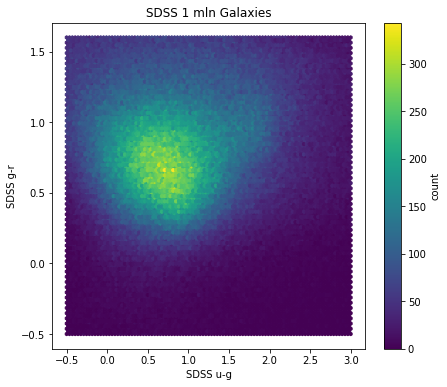

In [21]:
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(7,6))
img = ax.hexbin(u-g , g-r , extent=(-0.5,3,-0.5, 1.6))
ax.set_title('SDSS 1 mln Galaxies')
ax.set_xlabel('SDSS u-g')
ax.set_ylabel('SDSS g-r')
plt.colorbar(img, label='count')

Plot 1 million of Stars  : OBJC_TYPE == 6 . 

In [23]:
%%time
# select stars,  
# ensure non-negative fluxes ...
sdsst = sdss.select(['u','g','r','OBJC_TYPE', 'obj_type',
                    'uExt', 'gExt']).\
    where(sdss['OBJC_TYPE'] == 6).\
    where((sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0) ).\
    limit(1000000).toPandas()

# convert to mags ...
u =  -2.5 * np.log10(sdsst['u']) + 22.5
g =  -2.5 * np.log10(sdsst['g']) + 22.5
r =  -2.5 * np.log10(sdsst['r']) + 22.5


CPU times: user 19.3 s, sys: 2 s, total: 21.3 s
Wall time: 8.35 s


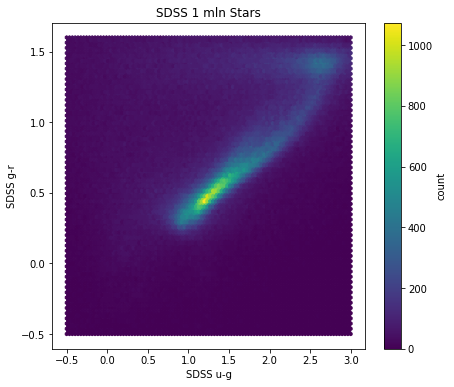

In [24]:
%matplotlib inline

fig,ax = plt.subplots(1,1,figsize=(7,6))
img = ax.hexbin(u-g , g-r , extent=(-0.5,3,-0.5, 1.6))
ax.set_title('SDSS 1 mln Stars')
ax.set_xlabel('SDSS u-g')
ax.set_ylabel('SDSS g-r')
plt.colorbar(img, label='count')



Looks pretty!  Exactly what I'd expect from a stellar locus.  

So in summary, to select stars, with non-negative fluxes, we want : 

    * OBJC_TYPE == 6 
    * u > 0 , g > 0 , r > 0 , i>0,  z>0 (fluxes)
    

#### (can skip) Select subset of the SDSS table for crossmatching 

There are billions of stars in the SDSS catalog - we may want to skip the very faint ones. Also, since there may be some junk at faint end, need to select stars brighter than eg. 22.5 mag in u ... To do that need to use  a pyspark function  `sparklog10`.  So first find out how many there are  (this is done by only applying `.where().count()`,  instead of `.select().where()` )  : 

In [30]:
%%time

# first count : do  .where().count()
# limit at  g < 20 magnitude 

from pyspark.sql.functions import log10 as sparklog10
limitMag = 20 
a = sdss.where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
          ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag)).count()
print(a)

98735687
CPU times: user 6.18 ms, sys: 1.02 ms, total: 7.19 ms
Wall time: 5.92 s


In [6]:
%%time 
# now do the  selection  :  .select().where()
from pyspark.sql.functions import log10 as sparklog10
limitMag = 20 
sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))

CPU times: user 7.57 ms, sys: 6.21 ms, total: 13.8 ms
Wall time: 688 ms


#### (can skip) Inspect further ZTF ... 

First,  show with Pandas what the ZTF matchfiles look like : 

In [16]:
# this average doesn't work, I don't know why ...
#from pyspark.sql.functions import first, avg
#ztf_lct = ztf_lc.select(['matchid', 'ra', 'dec', 'zone', 'dup', 
#               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
#               'medianmag','meanmag',
#'nbestobs', 'ngoodobs', 'nobs','bestmedianmag', 'filterid', 'mag','mjd']).\
#  where(ztf_lc['ngoodobs']>100).groupBy(ztf_lc.matchid).\
#    agg(avg("filterid").alias("fid")).\
#    limit(1000).toPandas()
    

Either way, turns out that each row in ztf_1am_lc  corresponds to a different filter,  and different filters have different matchids. Select objects that have lots of obs to illustrate the point : 

In [18]:
ztf_lct = ztf_lc.select(['matchid', 'ra', 'dec', 'zone', 'dup', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag',
'nbestobs', 'ngoodobs', 'nobs','bestmedianmag', 'filterid', 'mag','mjd']).\
  where(ztf_lc['ngoodobs']>100).\
    limit(1000).toPandas()

In [7]:
#ztf_lct

As we see, each row of ztf_1am_lc  has a bunch of aggregate informations, and some column arrays. Each row corresponds to a different filterid  (as we see above,  filterid is the same for all obs in a given row ... ).

Thus, we need to first select rows that have obs from filterid=1,  then =2,  etc.  The majority of obs have either fid 1 or 2. 



Find out how many rows we are talking about ... 

In [ ]:
#%%time
#ztf_lc.where((ztf_lc['ngoodobs']>500) & (array_contains(ztf_lc['filterid'], 1))).count()
    

Select subset of ZTF to crossmatch 

In [20]:
# Need to select each filter individually 
# First filterid = 1,  then =2,  then=3  

First , count how many ZTF objects have over 10 obs in filterid 1 

In [32]:
%%time 
# 
from pyspark.sql.functions import array_contains
# Use this function to select only rows that have 
# a  given filterid 

a = ztf_lc.where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], 1))).count()
print(a)

48301066
CPU times: user 72.2 ms, sys: 20.9 ms, total: 93.1 ms
Wall time: 6min 15s


Ensure that there are no columns with duplicate names between SDSS and ZTF :  

    ZTF : 'zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs'
            
    SDSS : 'zone','dup', 'RA', 'DEC', 'u','g','r','i',
            'uErr','gErr', 'rErr', 'iErr', 
        
( there aren't : `zone` and `dup` are required and are handled internally  )

### The actual ZTF-SDSS crossmatching 

In [ ]:
###  Minimal working example : crossmatch ZTF LC to SDSS ####
    
from axs import Constants
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import log10 as sparklog10
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
import pyspark

spark = pyspark.sql.SparkSession.builder \
    .config('spark.master', "local[8]")\
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "16g") \
    .config("spark.cores.max", "15") \
    .config("spark.executor.cores", "1") \
    .enableHiveSupport() \
    .getOrCreate()
     
axs_catalog = AxsCatalog(spark)

ztf_lc = axs_catalog.load("ztf_1am_lc")
sdss = axs_catalog.load("sdss_zoned1am_hd")

In [6]:
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import log10 as sparklog10

# select SDSS stars ... 
limitMag = 20 
sdss_sel = sdss.select(['zone', 'RA', 'DEC', 'u','g','r','i',
                        'uErr','gErr', 'rErr', 'iErr', 'dup']).\
    where((sdss['OBJC_TYPE'] == 6) & (sdss['u'] > 0) &(sdss['g'] > 0)&(sdss['r'] > 0)&\
    ((-2.5 * sparklog10(sdss['g']) + 22.5) < limitMag))
    



In [8]:
from axs import Constants
# select ZTF obs in a given filter, with over 10 good obs ...
fid = 3 
ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))
        
# crossmatch 
print('Crossmatching ZTF fid=%d to SDSS stars  g < %.2f...'%(fid, limitMag))
fname = "ztf_fid"+str(fid)+"_sdss_stars_lt"+str(limitMag)+"_2asec"
print('Saving to ', fname)
    
crossmatch = ztf_lc_fid.\
    crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
    save_axs_table(fname)

Crossmatching ZTF fid=3 to SDSS stars  g < 20.00...
Saving to  ztf_fid3_sdss_stars_lt20_2asec


Inspect:

In [11]:
crossmatch?

#### Crossmatch ZTF to SDSS  : 

Crossmatch ZTF fid=1 (2,3), i.e. 	ZTF g, ZTF r, ZTF i,   to SDSS with matching radius of 2 arcsec : 

In [15]:
%%time

# we don't limit the extent, or express to Pandas , since 
# wer're trying to crossmatch within AXS framework  

from axs import Constants
from pyspark.sql.functions import array_contains

# Loop over fid = 1,2,3 .... 

for fid in [1,2,3] : 
    ztf_lc_fid = ztf_lc.select(['zone', 'dup', 'matchid', 'ra', 'dec', 
               'bestmagrms', 'bestmeanmag', 'bestmedianmag',
               'medianmag','meanmag','nbestobs', 'ngoodobs']).\
      where((ztf_lc['ngoodobs']>10) & (array_contains(ztf_lc['filterid'], fid)))
        
    print('Crossmatching ZTF fid=%d to SDSS stars  g < %.2f...'%(fid, limitMag))
    fname = "ztf_fid"+str(fid)+"_sdss_stars_lt"+str(limitMag)+"_2asec"
    print('Saving to ', fname)
    
    
    #ztf_lc_fid = ztf_lc_fid.withColumnRenamed('zone', 'ztf_zone')
    #ztf_lc_fid.withColumnRenamed('dup', 'ztf_dup')
    
    
    crossmatch = ztf_lc_fid.\
        crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
        save_axs_table(fname)
    
    
    #crossmatch = ztf_lc_fid.withColumnRenamed("dup", "ztf_dup").\
    #    withColumnRenamed("zone", "ztf_zone").\
    #    crossmatch(sdss_sel, r=2*Constants.ONE_ASEC).\
    #    save_axs_table(fname)
    
    # withColumnRenamed("dup", "ztf_dup").\
     #   withColumnRenamed("zone", "ztf_zone")

Crossmatching ZTF fid=1 to SDSS stars  g < 20.00...
Saving to  ztf_fid1_sdss_stars_lt20_2asec


Py4JJavaError: An error occurred while calling o448.saveAsTable.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:196)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.datasources.DataSource.writeAndRead(DataSource.scala:503)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.saveDataIntoTable(createDataSourceTables.scala:217)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.run(createDataSourceTables.scala:176)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:670)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:670)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:670)
	at org.apache.spark.sql.DataFrameWriter.createTable(DataFrameWriter.scala:468)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:447)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:403)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 15 in stage 1.0 failed 4 times, most recent failure: Lost task 15.3 in stage 1.0 (TID 60, 140.142.4.22, executor 13): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/lib/pyspark.zip/pyspark/worker.py", line 261, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:418)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:372)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$7.apply(Executor.scala:367)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1348)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:373)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1867)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1866)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1866)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2100)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2049)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2038)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:166)
	... 35 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/epyc/opt/spark-axs/python/lib/pyspark.zip/pyspark/worker.py", line 261, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:418)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:172)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:122)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:372)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:98)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:96)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:127)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:89)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$7.apply(Executor.scala:367)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1348)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:373)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [48]:
#%%time 
#c = ztf_lc.where(ztf_lc['ngoodobs']>1000).count()
#print(c)

In [49]:
# No need to store before we can crossmatch to SDSS : 
#%%time 
#axs_catalog.save_axs_table(ztf_lc_fid, "ztf_lc_fid_temp_table3")

AxsFrame[ztf_zone: bigint, dup: int, matchid: string, ra: double, dec: double, ztf_zone: bigint, dup: int, bestmagrms: double, bestmeanmag: double, bestmedianmag: double, medianmag: double, meanmag: double, nbestobs: bigint, ngoodobs: bigint]

In [25]:
%%time 
from axs import Constants
crossmatch = ztf_lc_fid.crossmatch(sdss_sel, r=2*Constants.ONE_ASEC)

CPU times: user 13.7 ms, sys: 2.16 ms, total: 15.8 ms
Wall time: 168 ms


In [ ]:
crossmatch.count()

In [ ]:
crossmatch.save_axs_table("ztf_fid1_sdss_stars_2asec")

In [ ]:
np.arange

In [68]:
from axs.catalog import AxsCatalog
from axs.axsframe import AxsFrame
axs_catalog = AxsCatalog()
ztf = axs_catalog.load("ztf_1am")
sdss = axs_catalog.load("sdss_zoned1am_hd")

from pyspark.sql.functions import first, avg
ztf_agg = ztf.select(ztf.zone, ztf.objectId, ztf.fid, 
                     ztf.classtar, ztf.magpsf, ztf.sigmapsf, 
                     ztf.ra, ztf.dec, ztf.jd).where((ztf.fid == "1") &\
                    (ztf.classtar > 0.5)).groupBy(ztf.objectId).\
                        agg(first("zone").alias("zone"), 
                        first("objectId").alias("objectId2"), 
                        first("fid").alias("fid"), 
                        first("classtar").alias("classtar"), 
                        avg("magpsf").alias("avg_magpsf_g"), 
                        avg("sigmapsf").alias("avg_sigmapsf_g"), 
                        avg("ra").alias("ra"), 
                        avg("dec").alias("dec"),
                        avg("jd").alias("avg_jd"))
    
    


TypeError: __init__() missing 1 required positional argument: 'spark_session'

In [37]:
import numpy as np
np.unique(ztf_agg.columns, return_counts=True)

(array(['avg_jd', 'avg_magpsf_g', 'avg_sigmapsf_g', 'classtar', 'dec',
        'fid', 'objectId', 'objectId2', 'ra', 'zone'], dtype='<U14'),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

Now need to store before we can crossmatch to SDSS : 

In [38]:
%%time 
axs_catalog.save_axs_table(ztf_agg, "ztf_agg_temp_table")

Py4JJavaError: An error occurred while calling o472.saveAsTable.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:233)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:154)
	at org.apache.spark.sql.execution.datasources.DataSource.writeAndRead(DataSource.scala:529)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.saveDataIntoTable(createDataSourceTables.scala:216)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.run(createDataSourceTables.scala:176)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter.createTable(DataFrameWriter.scala:458)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:437)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:393)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 16.0 failed 4 times, most recent failure: Lost task 3.3 in stage 16.0 (TID 3549, 128.95.79.19, executor 4): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:294)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:206)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:205)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Mkdirs failed to create file:/epyc/projects/lsd2/pzwarehouse/ztf_agg_temp_table/_temporary/0/_temporary/attempt_20180822171747_0016_m_000003_3 (exists=false, cwd=file:/data/epyc/opt/spark-2.3.0-smj/work/app-20180822155624-0001/4)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:455)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:241)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:342)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:302)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:151)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask.org$apache$spark$sql$execution$datasources$FileFormatWriter$DynamicPartitionWriteTask$$newOutputWriter(FileFormatWriter.scala:520)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask$$anonfun$execute$5.apply(FileFormatWriter.scala:555)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask$$anonfun$execute$5.apply(FileFormatWriter.scala:536)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask.execute(FileFormatWriter.scala:536)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:276)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1357)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:281)
	... 8 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2030)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:203)
	... 33 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:294)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:206)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:205)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: Mkdirs failed to create file:/epyc/projects/lsd2/pzwarehouse/ztf_agg_temp_table/_temporary/0/_temporary/attempt_20180822171747_0016_m_000003_3 (exists=false, cwd=file:/data/epyc/opt/spark-2.3.0-smj/work/app-20180822155624-0001/4)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:455)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:241)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:342)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:302)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:151)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask.org$apache$spark$sql$execution$datasources$FileFormatWriter$DynamicPartitionWriteTask$$newOutputWriter(FileFormatWriter.scala:520)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask$$anonfun$execute$5.apply(FileFormatWriter.scala:555)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask$$anonfun$execute$5.apply(FileFormatWriter.scala:536)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1336)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$DynamicPartitionWriteTask.execute(FileFormatWriter.scala:536)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:278)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:276)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1357)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:281)
	... 8 more


In [ ]:
ztf_agg_axs = axs_catalog.load("ztf_agg_temp_table")
ztf_agg_axs.crossmatch(sdss)

### Load AXS tables

In [7]:
sdss = axs_catalog.load("sdss_zoned1am_hd")
ztf = axs_catalog.load("ztf_1am")

In [41]:
sdss.count()

768618139

In [40]:
ztf.count()

15569370

Print the first row : 

In [10]:
sdss.head()

Row(index=29749, RUN=6361, CAMCOL=1, FIELD=110, ID=565, OBJC_TYPE=3, OBJC_FLAGS=268435968, OBJC_FLAGS2=0, RA=5.241996635503199, DEC=-16.26120978208088, RESOLVE_STATUS=17, uExt=0.13187265396118164, gExt=0.0970306396484375, rExt=0.07037471234798431, iExt=0.05336301401257515, zExt=0.03783504292368889, u=0.8058638572692871, g=1.0961277484893799, r=2.518923759460449, i=3.779599905014038, z=5.626303672790527, uErr=10.498696327209473, gErr=79.64900207519531, rErr=38.9918212890625, iErr=18.439966201782227, zErr=1.252055048942566, uCalib=1, gCalib=1, rCalib=1, iCalib=1, zCalib=1, obj_type=1, obj_index=344036178871, zone=4424, dup=0)

### Cross-matching catalogs

You can cross-match two catalogs, using 2'' as the matching distance, and counting the results like this:

In [42]:
from axs import Constants
ztf.crossmatch(sdss, r=2*Constants.ONE_ASEC).count()

11844046

Note: If `r` is not specified, the default is `Constants.ONE_ASEC`.

Saving the results with ALL columns as a new table (takes about 30 minutes). When saving as a new table, Spark complains if there are duplicate column names, so we need to change them first.

Note: The tables `gaia_sdss_3asec` (cross-match of gaia and sdss with 3 arc-sec distance) and `gaia_sdss_wise_1asec` (cross-match of gaia, sdss and wise with 1 arc-sec distance) have already been calculated and are available for use.

In [50]:
%%time 
ztf.withColumnRenamed("obj_index", "ztf_obj_index").withColumnRenamed("index", "ztf_index").\
crossmatch(sdss, r=2*Constants.ONE_ASEC).\
save_axs_table2("ztf_sdss_2asec")

AttributeError: 'AxsFrame' object has no attribute 'save_axs_table2'

In [60]:
import numpy as np 
np.asarray(ztf.columns)[np.in1d(ztf.columns,sdss.columns)]

array(['zone', 'dup'], dtype='<U11')

In [62]:
ztf.withColumnRenamed("zone", "ztf_zone")
ztf.withColumnRenamed("dup", "ztf_dup")

DataFrame[objectId: string, jd: double, fid: int, pid: bigint, diffmaglim: double, programid: int, candid: bigint, isdiffpos: string, tblid: int, nid: int, rcid: int, field: int, xpos: double, ypos: double, ra: double, dec: double, magpsf: double, sigmapsf: double, chipsf: double, magap: double, sigmagap: double, distnr: double, magnr: double, sigmagnr: double, chinr: double, sharpnr: double, sky: double, magdiff: double, fwhm: double, classtar: double, mindtoedge: double, magfromlim: double, seeratio: double, aimage: double, bimage: double, aimagerat: double, bimagerat: double, elong: double, nneg: int, nbad: int, rb: double, ssdistnr: double, ssmagnr: double, ssnamenr: string, sumrat: double, magapbig: double, sigmagapbig: double, ranr: double, decnr: double, sgmag1: double, srmag1: double, simag1: double, szmag1: double, sgscore1: double, distpsnr1: double, ndethist: int, ncovhist: int, jdstarthist: double, jdendhist: double, scorr: double, tooflag: int, objectidps1: bigint, objecti

In [65]:
%%time 
ztf.withColumnRenamed("obj_index", "ztf_obj_index").\
withColumnRenamed("index", "ztf_index").\
withColumnRenamed("field", "ztf_field").\
crossmatch(sdss, r=2*Constants.ONE_ASEC).\
save_axs_table("ztf_sdss_2asec")

Py4JJavaError: An error occurred while calling o855.saveAsTable.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:233)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:154)
	at org.apache.spark.sql.execution.datasources.DataSource.writeAndRead(DataSource.scala:529)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.saveDataIntoTable(createDataSourceTables.scala:216)
	at org.apache.spark.sql.execution.command.CreateDataSourceTableAsSelectCommand.run(createDataSourceTables.scala:176)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:656)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:656)
	at org.apache.spark.sql.DataFrameWriter.createTable(DataFrameWriter.scala:458)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:437)
	at org.apache.spark.sql.DataFrameWriter.saveAsTable(DataFrameWriter.scala:393)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 17.0 failed 4 times, most recent failure: Lost task 3.3 in stage 17.0 (TID 1526, 128.95.79.19, executor 1): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/epyc/opt/spark-2.3.0-smj/python/pyspark/worker.py", line 216, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:300)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:114)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:254)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:90)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:88)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:131)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:93)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2030)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:203)
	... 33 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/epyc/opt/spark-2.3.0-smj/python/pyspark/worker.py", line 216, in main
    ("%d.%d" % sys.version_info[:2], version))
Exception: Python in worker has different version 2.7 than that in driver 3.6, PySpark cannot run with different minor versions.Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:300)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:164)
	at org.apache.spark.sql.execution.python.ArrowPythonRunner$$anon$1.read(ArrowPythonRunner.scala:114)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:254)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec$$anon$2.<init>(ArrowEvalPythonExec.scala:90)
	at org.apache.spark.sql.execution.python.ArrowEvalPythonExec.evaluate(ArrowEvalPythonExec.scala:88)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:131)
	at org.apache.spark.sql.execution.python.EvalPythonExec$$anonfun$doExecute$1.apply(EvalPythonExec.scala:93)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:800)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [35]:
region = gaia.region(ra1=40, dec1=42, ra2=40.5, dec2=42.5)
region.count()

2836

You can also calculate a histogram from the cross-matched data. The arguments are:
- the column (expression) to compute it on
- the resulting column name
- number of bins

Should take about 3.5 minutes.

In [41]:
hist = crossmatch.histogram(crossmatch.g - crossmatch.phot_g_mean_mag,
                       "magdiff", 100)
hist.show()

+----+-----+
| bin|count|
+----+-----+
| 148| 5037|
|2122|   26|
| 307| 1319|
| 496|  530|
| 229| 2258|
|1342|   72|
| 766|  200|
|1088|  105|
|2366|   29|
|1545|   55|
| 833|  168|
|1591|   41|
|6357|    3|
|6454|    1|
|2983|   14|
|4101|    7|
|7638|    2|
|3918|    4|
|6685|    2|
|4916|    4|
+----+-----+
only showing top 20 rows



### Using light-curve data

This is still under development and the currently loaded catalogs do not have light-curve columns.

In [45]:
spark.catalog.listTables()

[Table(name='allwise_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='demo_result', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_1am_dup', database='default', description=None, tableType='EXTERNAL', isTemporary=False),
 Table(name='gaia_dr2_700lc', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_700lc_new', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_ebv', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_dr2_sfd', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_sdss_3asec', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='gaia_sdss